## Imports and stuff

In [54]:
import tensorflow as tf
import keras
from keras.layers import Dense,Dropout, Activation
from keras.models import Sequential
from keras.optimizers import *

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
from sklearn.linear_model import LogisticRegression, Lasso, ElasticNet
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

In [57]:
X_train = np.array(np.load("X_train_divided.npy"))
y_train = np.array(np.load("y_train_divided.npy"))
X_test = np.array(np.load("X_test_divided.npy"))
y_trainonehot = np.array(pd.get_dummies(y_train))
X_train = scale(X_train)
X_test = scale(X_test)

## Neural Network

In [58]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [62]:
scores = []
cv = 1
for i in range(cv):
    model = Sequential()
    model.add(Dense(80, input_dim = 150))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(40))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(15))
    model.add(Activation('softmax'))
    #optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-4)
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

    X,y = X_train,y_trainonehot
    X,y = unison_shuffled_copies(X, y)
    
    history = model.fit(X,y, batch_size = 10, nb_epoch = 20, 
                        verbose = 1, validation_split = 0.5,)
    score1 = model.evaluate(X,y,verbose=0)
    #score2 = model.evaluate(X_dev,y_devonehot,verbose=0)
    #print(score1[1], score2[1])
    #scores.append((score1[1]+score2[1])/2)
#print("Mean score:",np.mean(scores))

Train on 4355 samples, validate on 4356 samples
Epoch 1/20
4355/4355 [==============================] - 1s - loss: 1.5768 - acc: 0.5132 - val_loss: 0.5811 - val_acc: 0.8572
Epoch 2/20
4355/4355 [==============================] - 0s - loss: 0.6482 - acc: 0.7920 - val_loss: 0.2810 - val_acc: 0.9258
Epoch 3/20
4355/4355 [==============================] - 0s - loss: 0.3872 - acc: 0.8742 - val_loss: 0.1880 - val_acc: 0.9513
Epoch 4/20
4355/4355 [==============================] - 0s - loss: 0.2957 - acc: 0.9054 - val_loss: 0.1325 - val_acc: 0.9637
Epoch 5/20
4355/4355 [==============================] - 0s - loss: 0.2282 - acc: 0.9256 - val_loss: 0.1129 - val_acc: 0.9665
Epoch 6/20
4355/4355 [==============================] - 0s - loss: 0.1884 - acc: 0.9417 - val_loss: 0.0941 - val_acc: 0.9750
Epoch 7/20
4355/4355 [==============================] - 0s - loss: 0.1823 - acc: 0.9378 - val_loss: 0.0868 - val_acc: 0.9741
Epoch 8/20
4355/4355 [==============================] - 0s - loss: 0.1467 - a

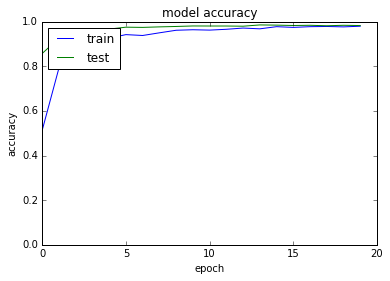

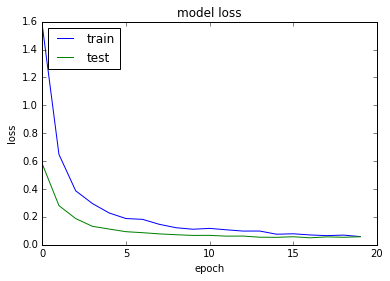

In [63]:
%matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0,1))
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [64]:
nn_pred = model.predict(X_test)
nn_pred = [np.argmax(nn_pred[i]) for i in range(len(nn_pred))]
np.savetxt('y_pred.txt', nn_pred, fmt="%d")
print(np.unique(nn_pred,return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14], dtype=int64), array([168, 230, 158, 158, 217, 186, 221, 312, 229, 153, 122, 160, 247,
       118, 301], dtype=int64))


In [67]:
new_pred = []   
preds = {}
for i in range(298):
    preds[i] = []
    preds[i].extend(nn_pred[10*i:10*i+10])
for x in preds.values():
    count = Counter(x)
    new_pred.append(count.most_common()[0][0])
np.savetxt('y_pred.txt', new_pred, fmt="%d")

## Regression Logistique ftw

In [10]:
reg = LogisticRegression()
reg.fit(np.concatenate([X_train,X_dev]),np.concatenate([y_train,y_dev]))
#clf.fit(X_dev, y_dev)
reg_pred = reg.predict(X_test)
np.savetxt('y_pred.txt', reg_pred, fmt="%d")

## SVM

In [73]:
from sklearn.svm import SVC
#X = np.concatenate([X_train,X_dev])
#y = np.concatenate([y_train,y_dev])
X,y = X_train_noise, y_train_noise

X,y = unison_shuffled_copies(X, y)
svm = SVC()
svm.fit(X,y)
svm_pred = svm.predict(X_test)
np.savetxt('y_pred.txt', svm_pred, fmt="%d")
print(np.unique(svm_pred,return_counts=True))
svm_pred = svm.predict(X_test)

(array([12]), array([298], dtype=int64))
1.0


# K-means

In [12]:
from sklearn.cluster import KMeans
import operator
dict_list = []
for i in range(15):
    dict_list.append({})
kmeans = KMeans(n_clusters=15, random_state=0).fit(X_tot)
X = np.concatenate([X_train,X_dev])
y = np.concatenate([y_train,y_dev])
pred = kmeans.predict(X)
#print(pred, y)
for i in range(len(pred)):
    try:
        dict_list[pred[i]][y[i]] += 1
    except:
        dict_list[pred[i]][y[i]] = 1
#print(dict_list)
corr_dict = {}
for i in range(15):
    try:
        corr_dict[i] = max(dict_list[i].items(), key=operator.itemgetter(1))[0]
    except:
        corr_dict[i] = None
        
for i in range(len(pred)):
    pred[i] = corr_dict[pred[i]]

In [13]:
"""y_new = []
pred_new = []
new_class = {3:1,13:1,14:1,11:4,12:4,9:4,6:4,7:4,10:4}
for i in range(len(y)):
    try:
        y_new.append(new_class[y[i]])        
    except:
        y_new.append(y[i])
    try:
        pred_new.append(new_class[pred[i]])
    except:
        pred_new.append(pred[i])"""
from sklearn.metrics import confusion_matrix, accuracy_score
print(confusion_matrix(y,pred))
print(accuracy_score(y,pred))

[[ 0  0  3  0  0 29  0  0  7  0  0  0 15  0  5]
 [ 0 42  0  0  0  0  0  0  4  0  0  0  2  0 11]
 [ 0  0 49  0  0  0  0  0  0  0  8  0  0  0  0]
 [ 0  9  0  0  0  0  0  0  0  0  0  0  9  0 41]
 [ 0  0  3  0  0 29  0  0  0  0  0  0 27  0  0]
 [ 0  0  2  0  0 30  0  0  1  0  0  0 27  0  0]
 [ 0  0  8  0  0  5 36  0  0  0  9  0  0  0  1]
 [ 0  0 11  0  0  7  1  0 13  0  7  0 17  0  2]
 [ 0  0  1  0  0  4  0  0 44  0  7  0  2  0  0]
 [ 0  0 16  0  0 14  0  0  7  0  1  0 16  0  2]
 [ 0  0  0  0  0  0  0  0  0  0 60  0  0  0  0]
 [ 0  0  1  0  0 21  0  0  3  0  0  0 33  0  0]
 [ 0  0  0  0  0 13  2  0  0  0  0  0 44  0  0]
 [ 0  0  1  0  0  4  0  0  0  0  0  0 12  5 33]
 [ 0  1  0  0  0  1  0  0  2  0  0  0  2  0 50]]
0.412844036697


## XGBoost 

In [29]:
import os
mingw_path = 'C:\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost as xgb

gbm = xgb.XGBClassifier()
X = np.concatenate([X_train,X_dev])
y = np.concatenate([y_train,y_dev])
X,y = unison_shuffled_copies(X, y)
    
print(X.shape,y.shape)
gbm.fit(X, y)

(872, 150) (872,)


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [30]:
xgboost_pred = gbm.predict(X_test)
np.savetxt('y_pred.txt', xgboost_pred, fmt="%d")
print(gbm.score(X,y))
print(np.unique(xgboost_pred,return_counts=True))

1.0
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), array([16, 22, 26, 16, 21, 15, 26, 25, 18, 23,  9, 23, 24, 10, 24], dtype=int64))


## Mix results 

In [16]:
new_pred = []
from collections import Counter
preds = {}
for i in range(len(nn_pred)):
    preds[i] = []
    #preds[i].append(nn_pred[i])
    preds[i].append(svm_pred[i])
    preds[i].append(reg_pred[i])
    preds[i].append(xgboost_pred[i])
for x in preds.values():
    count = Counter(x)
    new_pred.append(count.most_common()[0][0])
np.savetxt('y_pred.txt', new_pred, fmt="%d")
print(np.unique(new_pred,return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), array([31, 18,  9, 18, 18, 20, 27, 27, 25, 22,  9, 21, 23, 11, 19], dtype=int64))
